In [1]:
import pandas as pd
import numpy as np
from cherenkovdeconvolution import util
from mord import LogisticAT
from cherenkovdeconvolution import dsea
from sklearn.tree import ExtraTreeClassifier
from matplotlib import pyplot as plt
from sklearn.preprocessing import power_transform
import cherenkovdeconvolution.stepsize as stepsize
from sklearn.ensemble import RandomForestClassifier
df=pd.read_csv('sample.csv', nrows=500000)
X = df[['SplineMPEDirectHitsICE.n_dir_doms',
        'VariousVariables.Cone_Angle',
        'SplineMPECramerRaoParams.variance_theta',
        'Borderness.Q_ratio_in_border',
        'SplineMPETruncatedEnergy_SPICEMie_BINS_MuEres.value',
        #'SplineMPETruncatesEnergy_SPICEMie_DOMS_Neutrino.energy', That feature is not in my MC
        'SplineMPEDirectHitsICB.n_late_doms',
        'Dustyness.n_doms_in_dust',
        'LineFitGeoSplit1Params.n_hits',
        'SplineMPEDirectHitsICC.dir_track_hit_distribution_smoothness',
        'SPEFit2GeoSplit1BayesianFitParams.logl',
        'SplineMPECharacteristicsIC.avg_dom_dist_q_tot_dom']]
Y = df['MCPrimary.energy']

In [2]:
binning_E = np.logspace(np.log10(Y.min()-10),
np.log10(Y.max()+100), 13)    # creating 12 bins for the energy 
#Binning overflow & underflow manually
#overflow = 1e10
#bins_over = np.append(binning_E,overflow)
#binning_E = bins_over

Y = np.digitize(Y, binning_E)  

Y = Y - 1

bin_1=[i for i in binning_E[:-1]]
bin_2=[i for i in binning_E[1:]]
bin_centers = np.mean([bin_1, bin_2], axis=0)
n_test = int(len(df)/10)

X_train = X.iloc[n_test:]#splitting the dataframe
Y_train = Y[n_test:]

X_test = X.iloc[:n_test]
Y_test = Y[:n_test]

f_true = util.fit_pdf(Y_test) 
f_true

array([2.5592e-01, 3.6756e-01, 2.1952e-01, 9.6880e-02, 3.8640e-02,
       1.4100e-02, 4.6800e-03, 1.6600e-03, 6.8000e-04, 2.4000e-04,
       8.0000e-05, 4.0000e-05])

In [3]:
#Yeo-Johnson-Transformation
X_box= power_transform(X, method='yeo-johnson')    
X_btrain = X_box[n_test:]#splitting the dataframe
X_btest = X_box[:n_test]


0
1
2
3
Chi square distance between f_est and f_true: 0.2220793510698484


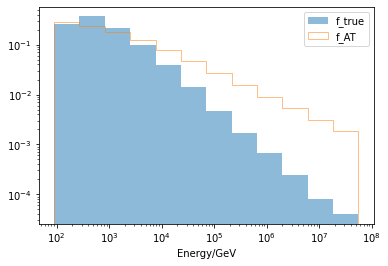

In [4]:
#logistic AT with decaying stepsize(transformed data)
def inspect_alpha(k, alpha, chi2s, f):
    print(alpha)


alpha_mul = stepsize.decay_mul(0.5)
f_AT_mul = dsea(X_btest, X_btrain, Y_train, LogisticAT(), K = 3, inspect = inspect_alpha, alpha = alpha_mul)
print('Chi square distance between f_est and f_true: {}'.format(util.chi2s(f_AT_mul, f_true)))
plt.hist(bin_centers, bins = binning_E, weights = f_true, alpha = 0.5,label ='f_true')
plt.hist(bin_centers, bins = binning_E, weights = f_AT_mul, alpha = 0.5,histtype = 'step',label='f_AT')
plt.gca().set_xscale('log')
plt.yscale('log')
plt.xlabel('Energy/GeV')
plt.legend(loc='best')
plt.show()

In [5]:
#trying out Tim Ruhes advice
Y = df['MCPrimary.energy']
binning_E = np.logspace(np.log10(Y.min()-10),# creating 12 bins for the energy 
np.log10(1e5), 13)    #limiting my energy to 1e5 GeV
#Binning overflow & underflow manually
overflow = 1e9
bins_over = np.append(binning_E,overflow)
binning_E = bins_over

Y = np.digitize(Y, binning_E)  

Y = Y - 1

bin_1=[i for i in binning_E[:-1]]
bin_2=[i for i in binning_E[1:]]
bin_centers = np.mean([bin_1, bin_2], axis=0)
#n_test = int(len(df)/10)


Y_train = Y[n_test:]


Y_test = Y[:n_test]

f_true = util.fit_pdf(Y_test) 
f_true


array([0.08536, 0.1916 , 0.20522, 0.17122, 0.12734, 0.0837 , 0.05384,
       0.03258, 0.02042, 0.01236, 0.0068 , 0.00434, 0.00522])

0
1
2
3
Chi square distance between f_est and f_true: 0.16351851376069956


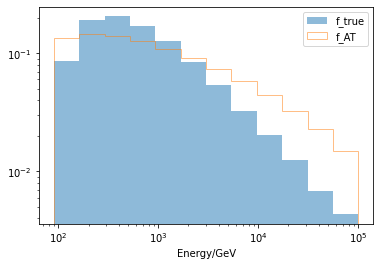

In [6]:
#logistic AT with decaying stepsize(transformed data+limit to 1e5 GeV)
def inspect_alpha(k, alpha, chi2s, f):
    print(alpha)


alpha_mul = stepsize.decay_mul(0.5)
f_AT_mul = dsea(X_btest, X_btrain, Y_train, LogisticAT(), K = 3, inspect = inspect_alpha, alpha = alpha_mul)
print('Chi square distance between f_est and f_true: {}'.format(util.chi2s(f_AT_mul, f_true)))
plt.hist(bin_centers, bins = binning_E[0:13], weights = f_true, alpha = 0.5,label ='f_true')
plt.hist(bin_centers, bins = binning_E[0:13], weights = f_AT_mul, alpha = 0.5,histtype = 'step',label='f_AT')
plt.gca().set_xscale('log')
plt.yscale('log')
plt.xlabel('Energy/GeV')
plt.legend(loc='best')
plt.show()

Chi square distance between f_est and f_true: 0.0003670241250109776


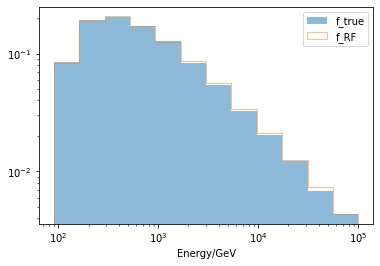

In [8]:
#Random Forrest for comperision
f_est= dsea(X_test, X_train, Y_train,RandomForestClassifier(), K=3)
print('Chi square distance between f_est and f_true: {}'.format(util.chi2s(f_est, f_true)))
plt.hist(bin_centers, bins = binning_E[0:13], weights = f_true, alpha = 0.5,label ='f_true')
plt.hist(bin_centers,  bins = binning_E[0:13], weights = f_est, alpha = 0.5,histtype = 'step',label='f_RF')
plt.gca().set_xscale('log')
plt.yscale('log')
plt.xlabel('Energy/GeV')
plt.legend(loc='best')
plt.show()

In [9]:
#running the full set
df=pd.read_csv('sample.csv')
X = df[['SplineMPEDirectHitsICE.n_dir_doms',
        'VariousVariables.Cone_Angle',
        'SplineMPECramerRaoParams.variance_theta',
        'Borderness.Q_ratio_in_border',
        'SplineMPETruncatedEnergy_SPICEMie_BINS_MuEres.value',
        #'SplineMPETruncatesEnergy_SPICEMie_DOMS_Neutrino.energy', That feature is not in my MC
        'SplineMPEDirectHitsICB.n_late_doms',
        'Dustyness.n_doms_in_dust',
        'LineFitGeoSplit1Params.n_hits',
        'SplineMPEDirectHitsICC.dir_track_hit_distribution_smoothness',
        'SPEFit2GeoSplit1BayesianFitParams.logl',
        'SplineMPECharacteristicsIC.avg_dom_dist_q_tot_dom']]
Y = df['MCPrimary.energy']

In [10]:
binning_E = np.logspace(np.log10(Y.min()-10),
np.log10(Y.max()+100), 13)    # creating 12 bins for the energy 
#Binning overflow & underflow manually
#overflow = 1e10
#bins_over = np.append(binning_E,overflow)
#binning_E = bins_over

Y = np.digitize(Y, binning_E)  

Y = Y - 1

bin_1=[i for i in binning_E[:-1]]
bin_2=[i for i in binning_E[1:]]
bin_centers = np.mean([bin_1, bin_2], axis=0)
n_test = int(len(df)/10)

X_train = X.iloc[n_test:]#splitting the dataframe
Y_train = Y[n_test:]

X_test = X.iloc[:n_test]
Y_test = Y[:n_test]

f_true = util.fit_pdf(Y_test) 
f_true

array([2.71180035e-01, 3.79863201e-01, 2.10853320e-01, 8.76662183e-02,
       3.29302254e-02, 1.16365910e-02, 3.92835237e-03, 1.30920085e-03,
       4.31151482e-04, 1.50715561e-04, 3.59917759e-05, 1.49965733e-05])

In [11]:
#Yeo-Johnson-Transformation
X_box= power_transform(X, method='yeo-johnson')    
X_btrain = X_box[n_test:]#splitting the dataframe
X_btest = X_box[:n_test]


0
1


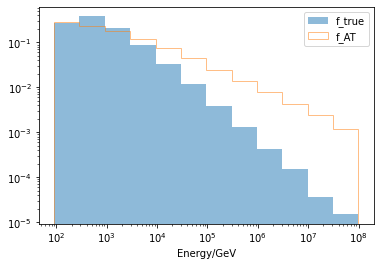

In [ ]:
#logistic AT with decaying stepsize(transformed data)
def inspect_alpha(k, alpha, chi2s, f):
    print(alpha)


alpha_mul = stepsize.decay_mul(0.5)
f_AT_mul,contr = dsea(X_btest, X_btrain, Y_train, LogisticAT(), K = 3, inspect = inspect_alpha, alpha = alpha_mul,return_contributions = True)
plt.hist(bin_centers, bins = binning_E, weights = f_true, alpha = 0.5,label ='f_true')
plt.hist(bin_centers, bins = binning_E, weights = f_AT_mul, alpha = 0.5,histtype = 'step',label='f_AT')
plt.gca().set_xscale('log')
plt.yscale('log')
plt.xlabel('Energy/GeV')
plt.legend(loc='best')
plt.show()

In [13]:
print('Chi square distance between f_est and f_true: {}'.format(util.chi2s(f_AT_mul, f_true)))

Chi square distance between f_est and f_true: 0.23316544574310885
